# Advection in Spherical coordinates
In this notebook, we will solve the advection equation in spherical coordinates using the finite volume method. The notebook serves as the first attempt at testing the implementation of advection and diffusion terms in `PyFVTool`, and might be removed in the future.

In [1]:
import sys
import os
import numpy as np
from tqdm import tqdm

current_dir = os.getcwd()
# print(current_dir)
target_dir = os.path.abspath(os.path.join(current_dir, "..", "src"))
sys.path.append(target_dir)
# # Use a raw string for the path
# sys.path.append(r'C:\projects\git\PyFVTool\src')

# # Print sys.path to verify the path is added
# print(sys.path)

In [2]:
# set the random seed! (good practice and needed for pytest_notebook)
np.random.seed(seed=12345)

In [3]:
from pyfvtool.mesh import SphericalGrid3D
import numpy as np

In [4]:
X = np.array([0.01, 0.1, 0.3, 0.5, 0.55, 1.0])
Y = np.array([0.0, 0.1, 1.0, 1.5, 2.9, 3.0, np.pi, 2 * np.pi])
Z = np.array([0.0, 0.01, 0.1, 0.5, 0.7, 0.95, 1.0, 1.25, 1.39, 2.0])
m_non = SphericalGrid3D(X, Y, Z)

In [5]:
import pyfvtool as pf

# Solving a 1D diffusion equation with a fixed concentration
# at the left boundary and a closed boundary on the right side


# Calculation parameters
def diffusion_spherical(mesh, t_simulation=7200.0, dt=60.0):
    c_left = 1.0  # left boundary concentration
    c_init = 0.0  # initial concentration
    D_val = 1e-5  # diffusion coefficient (gas phase)

    # Create a cell variable with initial concentration
    # By default, 'no flux' boundary conditions are applied
    c = pf.CellVariable(mesh, c_init)

    # Switch the right boundary to Dirichlet: fixed concentration
    c.BCs.right.a[:] = 0.0
    c.BCs.right.b[:] = 1.0
    c.BCs.right.c[:] = c_left
    if type(mesh) == SphericalGrid3D:
        # make top and bottom boundaries periodic
        c.BCs.top.periodic = True
        c.BCs.bottom.periodic = True

    c.apply_BCs()

    # Assign diffusivity to cells
    D_cell = pf.CellVariable(mesh, D_val)
    D_face = pf.geometricMean(
        D_cell
    )  # average value of diffusivity at the interfaces between cells

    # Time loop
    t = 0
    while t < t_simulation:
        # Compose discretized terms for matrix equation
        eqnterms = [pf.transientTerm(c, dt, 1.0), -pf.diffusionTerm(D_face)]

        # Solve PDE
        pf.solvePDE(c, eqnterms)
        t += dt
    return c

In [6]:
import pyfvtool as pf

# reload the module to get the updated version
import importlib

importlib.reload(pf)

import numpy as np
import matplotlib.pyplot as plt

# Solving a 3D diffusion equation with a fixed concentration
# at the left boundary and a closed boundary on the right side


# Calculation parameters
Nx = 20  # number of finite volume cells
Ntheta = 6  # number of cells in the theta direction; avoid theta=0 and theta=pi
Nphi = 5  # number of cells in the phi direction
Lx = 1.0  # [m] length of the domain

# Define mesh
mesh1 = pf.SphericalGrid1D(Nx, Lx)
c1 = diffusion_spherical(mesh1)
mesh3 = pf.SphericalGrid3D(Nx, Ntheta, Nphi, Lx, 2 * np.pi, 2 * np.pi)
c3 = diffusion_spherical(mesh3)
mesh1_rad = pf.CylindricalGrid1D(Nx, Lx)
c1_rad = diffusion_spherical(mesh1_rad)
mesh3_cyl = pf.CylindricalGrid3D(Nx, Ntheta, Nphi, Lx, 2 * np.pi, 2 * np.pi)
c3_cyl = diffusion_spherical(mesh3_cyl)

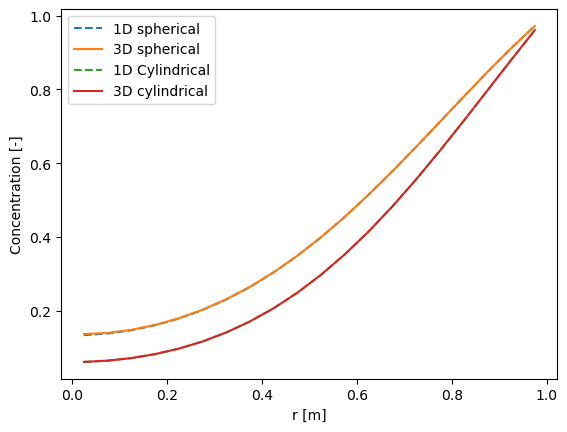

In [7]:
plt.plot(mesh1.cellcenters.r, c1.value, "--", label="1D spherical")
plt.plot(mesh3.cellcenters.r, c3.value[:, 0, 0], label="3D spherical")
plt.plot(mesh1_rad.cellcenters.r, c1_rad.value, "--", label="1D Cylindrical")
plt.plot(mesh3_cyl.cellcenters.r, c3_cyl.value[:, 0, 0], label="3D cylindrical")
plt.xlabel("r [m]")
plt.ylabel("Concentration [-]")
plt.legend();

In [8]:
# Advection example

r_earth = 6.371e6  # Earth radius [m]
v_wind_max = 10.0  # wind speed [m/s]
# ignoring diffusion
Nr = 20  # number of cells in the r direction
Ntheta = 36  # number of cells in the theta direction
Nphi = 36  # number of cells in the phi direction
Lr = 20e3  # [m] length of the domain in the r direction
r_face = np.linspace(r_earth, r_earth + Lr, Nr + 1)
theta_face = np.linspace(0, 2 * np.pi, Ntheta + 1)
phi_face = np.linspace(0, 2 * np.pi, Nphi + 1)
mesh = pf.SphericalGrid3D(r_face, theta_face, phi_face)
c = pf.CellVariable(mesh, 0.0)
# assign a concentration of 1.0 to 20 random locations
# c.value[0, np.random.randint(0, Ntheta, 20), np.random.randint(0, Nphi, 20)] = 1.0

# BC
# left boundary is a fixed concentration
c.BCs.left.a[:] = 0.0
c.BCs.left.b[:] = 1.0
c.BCs.left.c[:] = 0.0
# assign a concentration of 1.0 to a patch of left boundary
c.BCs.left.c[0:10, 0:10] = 1.0
# right boundary is a fixed concentration
c.BCs.right.a[:] = 0.0
c.BCs.right.b[:] = 1.0
c.BCs.right.c[:] = 0.0
# top and bottom boundaries are periodic
c.BCs.top.periodic = True
c.BCs.bottom.periodic = True
c.BCs.back.periodic = True
c.BCs.front.periodic = True
c.apply_BCs()
Mbc, RHSbc = pf.boundaryConditionsTerm(c.BCs)

# create a velocity field of random values between 0 and v_wind_max
v = pf.FaceVariable(mesh, [0.1, 10, 10])

Mc = pf.convectionUpwindTerm(v)

# Time loop
t = 0
dt = 100000.0
n_steps = 10
for i in tqdm(range(n_steps), bar_format='{desc}: {percentage:3.0f}% completed'):
    # Compose discretized terms for matrix equation
    Mt, RHSt = pf.transientTerm(c, dt, 1.0)
    M = Mt + Mc + Mbc
    RHS = RHSt + RHSbc
    c_new = pf.solveMatrixPDE(mesh, M, RHS)
    c.update_value(c_new)
    t += dt
c.value[0, :, :]

100% completed


array([[ 5.89804767e-01,  7.27416448e-01,  7.91630832e-01, ...,
         9.62959953e-09,  4.49350281e-09,  2.09682288e-09],
       [ 8.00973430e-01,  9.01522946e-01,  9.27988217e-01, ...,
         8.04840894e-10,  3.75566149e-10,  1.75251951e-10],
       [ 8.72372945e-01,  9.48267387e-01,  9.61967470e-01, ...,
         6.78442444e-11,  3.16583983e-11,  1.47728726e-11],
       ...,
       [-2.23244945e-41, -4.27097806e-41, -3.12493815e-41, ...,
        -1.22060132e-42,  8.53818325e-42, -5.96681651e-41],
       [-8.97913937e-43, -6.67880005e-42, -1.95372565e-42, ...,
        -2.18650447e-43,  1.52958514e-42, -1.06875495e-41],
       [-1.17106375e-42, -3.69272419e-43, -9.85419819e-43, ...,
         2.09662775e-43, -1.83183990e-42,  7.87815218e-43]])

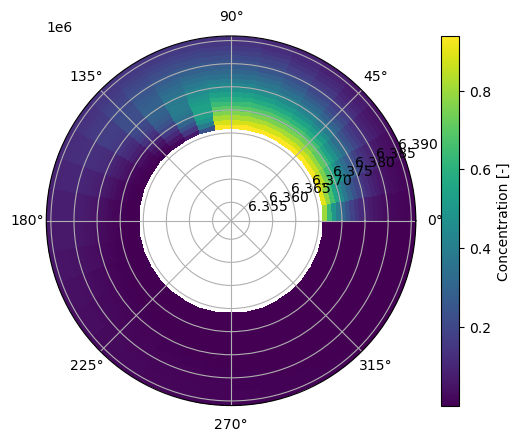

In [9]:
# visualize the result
r = mesh.cellcenters.r
theta = mesh.cellcenters.theta
R, Theta = np.meshgrid(r, theta)
X = R * np.sin(Theta)
Y = R * np.cos(Theta)
Z = c.value[:, 1, :].transpose()
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
# set the color range between 0 and 1
cax = ax.pcolormesh(Theta, R, Z, cmap="viridis")
fig.colorbar(cax, label="Concentration [-]")
# zoom in to the region of interest
ax.set_ylim([r_earth - Lr, r_earth + Lr])
plt.show()

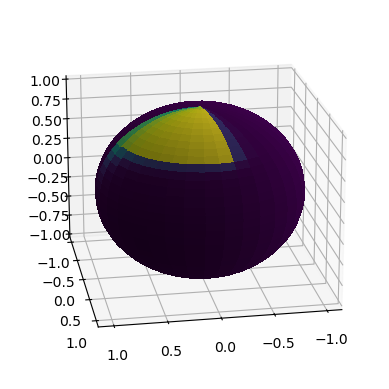

In [10]:
# Assuming c.value[5, :, :] is the data with size 16x16
data = c.value[1, :, :]  # Replace this with your actual data

# Generate theta and phi values
theta = np.linspace(0, np.pi, data.shape[0])
phi = np.linspace(0, 2 * np.pi, data.shape[1])
theta, phi = np.meshgrid(theta, phi)

# Convert spherical coordinates to Cartesian coordinates
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the surface
ax.plot_surface(
    x, y, z, facecolors=plt.cm.viridis(data), rstride=1, cstride=1, antialiased=False
)

# rotate the plot
ax.view_init(elev=20, azim=80)


# Show the plot
plt.show()

In [11]:
c.value.min(), c.value.max()

(-1.76591104523525e-18, 1.0017580578926588)

In [12]:
# advective transport 3D cylindrical example
r_earth = 6.371e6  # Earth radius [m]
v_wind_max = 10.0  # wind speed [m/s]
L = r_earth
# ignoring diffusion
Nr = 20  # number of cells in the r direction
Ntheta = 16  # number of cells in the theta direction
Nz = 16  # number of cells in the phi direction
Lr = 20e3  # [m] length of the domain in the r direction
r_face = np.linspace(0, Lr, Nr + 1)
theta_face = np.linspace(0, 2 * np.pi, Ntheta + 1)
L_face = np.linspace(0, L, Nz + 1)
mesh = pf.CylindricalGrid3D(r_face, theta_face, L_face)
c = pf.CellVariable(mesh, 0.0)
# assign a concentration of 1.0 to 20 random locations
c.value[0, np.random.randint(0, Ntheta, 20), np.random.randint(0, Nz, 20)] = 1000.0

# BC
# top and bottom boundaries are periodic
c.BCs.top.periodic = True
c.BCs.bottom.periodic = True
c.apply_BCs()
Mbc, RHSbc = pf.boundaryConditionsTerm(c.BCs)

# create a velocity field of random values between 0 and v_wind_max
v = pf.FaceVariable(mesh, [0, 0.001, 0.0])
# v.thetavalue = np.random.rand(Nr, Ntheta+1, Nz) * v_wind_max
# v.thetavalue[:, 0, :] = 0.0  # no wind at the poles
# v.thetavalue[:, -1, :] = 0.0  # no wind at the poles

Mc = pf.convectionUpwindTerm(v)

# Time loop
t = 0
dt = 100000.0
t_simulation = 1 * dt
while t < t_simulation:
    # Compose discretized terms for matrix equation
    Mt, RHSt = pf.transientTerm(c, dt, 1.0)
    M = Mt + Mc + Mbc
    RHS = RHSt + RHSbc
    c_new = pf.solveMatrixPDE(mesh, M, RHS)
    c.update_value(c_new)
    t += dt
c.value[0, :, :]

array([[9.88982309e-05, 4.54000072e+01, 4.53799759e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.57395707e-03, 4.53851621e+01,
        1.74351967e+00, 1.53121216e+01, 1.98526430e-01, 1.53197829e+01,
        0.00000000e+00, 1.74442160e+00, 0.00000000e+00, 1.98526430e-01],
       [3.33721559e-05, 1.53197495e+01, 1.53129901e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.68554431e-04, 6.77875378e+02,
        5.88332165e-01, 5.16691253e+00, 6.69906320e-02, 6.67730136e+02,
        0.00000000e+00, 6.63149274e+02, 0.00000000e+00, 6.69906320e-02],
       [6.62560649e+02, 5.16948649e+00, 5.16720562e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.93084453e-04, 8.91302473e+02,
        1.98526430e-01, 1.74351967e+00, 2.26052761e-02, 2.25318431e+02,
        0.00000000e+00, 2.23772668e+02, 0.00000000e+00, 2.26052761e-02],
       [2.23574043e+02, 1.74438822e+00, 1.74361857e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.88982309e-05, 3.007

In [13]:
# hollow sphere
r_in = 0.5
r_out = 1.0
Nr = 20  # number of cells in the r direction
Ntheta = 16  # number of cells in the theta direction
Nphi = 16  # number of cells in the phi direction
r_face = np.linspace(r_in, r_out, Nr + 1)
theta_face = np.linspace(0.0, 2 * np.pi, Ntheta + 1)
phi_face = np.linspace(0.0, 2 * np.pi, Nphi + 1)
mesh = pf.SphericalGrid3D(r_face, theta_face, phi_face)
c = pf.CellVariable(mesh, 0.0)
# assign a concentration of 1 to left boundary
c.BCs.left.a[0:5, 0:5] = 0.0
c.BCs.left.b[0:5, 0:5] = 1.0
c.BCs.left.c[0:5, 0:5] = 1.0
# right boundary is a fixed concentration
c.BCs.right.a[:] = 0.0
c.BCs.right.b[:] = 1.0
c.BCs.right.c[:] = 0.0

# top and back boundaries are periodic
c.BCs.top.periodic = True
c.BCs.front.periodic = True

c.apply_BCs()
Mbc, RHSbc = pf.boundaryConditionsTerm(c.BCs)

v_wind_max = 0.01  # wind speed [m/s]
v = pf.FaceVariable(mesh, [0.05, 0.05, 0.05])
# v.phiavalue = np.random.rand(Nr, Ntheta+1, Nphi) * v_wind_max

Mc = pf.convectionUpwindTerm(v)

# Time loop
t = 0
dt = 1.0
n_step = 50

for i in tqdm(range(n_step),  bar_format='{desc}: {percentage:3.0f}% completed'):
    # Compose discretized terms for matrix equation
    Mt, RHSt = pf.transientTerm(c, dt, 1.0)
    M = Mt + Mbc + Mc
    RHS = RHSt + RHSbc
    c_new = pf.solveMatrixPDE(mesh, M, RHS)
    c.update_value(c_new)

100% completed


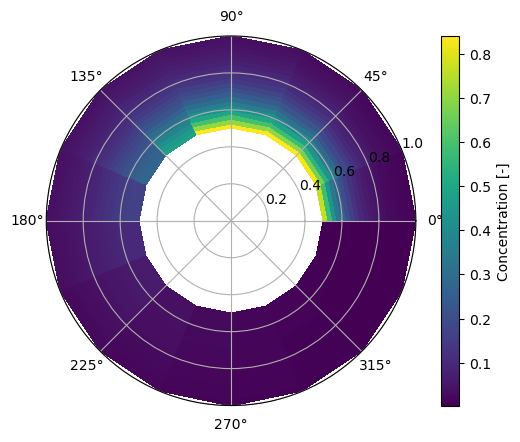

In [14]:
# visualize the result
r = mesh.cellcenters.r
theta = mesh.cellcenters.theta
R, Theta = np.meshgrid(r, theta)
X = R * np.sin(Theta)
Y = R * np.cos(Theta)
Z = c.value[:, 1, :].transpose()
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
# set the color range between 0 and 1
cax = ax.pcolormesh(Theta, R, Z, cmap="viridis")
fig.colorbar(cax, label="Concentration [-]");

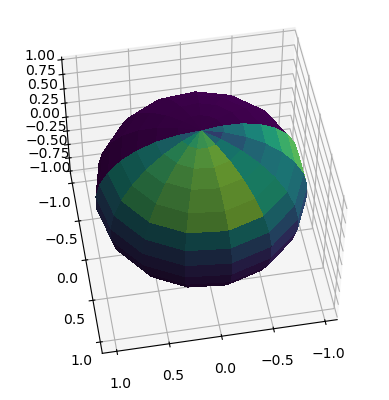

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming c.value[5, :, :] is the data with size 16x16
data = c.value[1, :, :]  # Replace this with your actual data

# Generate theta and phi values
theta = np.linspace(0, np.pi, data.shape[0])
phi = np.linspace(0, 2 * np.pi, data.shape[1])
theta, phi = np.meshgrid(theta, phi)

# Convert spherical coordinates to Cartesian coordinates
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the surface
ax.plot_surface(
    x, y, z, facecolors=plt.cm.viridis(data), rstride=1, cstride=1, antialiased=False
)

# rotate the plot
ax.view_init(elev=50, azim=80)


# Show the plot
plt.show()